# AVA-Speech Dataset for Voice Activity Detection (VAD)

This notebook demonstrates how to load and use the AVA-Speech dataset for training a binary voice activity detection model.

In [3]:
import os
import torch
import pandas as pd
import torchaudio
import requests
from torch.utils.data import Dataset
from pathlib import Path

torchaudio.set_audio_backend("soundfile")


class AVASpeechDataset(Dataset):
    """PyTorch Dataset for AVA-Speech with binary labels for VAD"""

    def __init__(
        self,
        labels_file,
        file_names_file,
        cache_dir="./cache",
        transform=None,
        sample_rate=16000,
        segment_length=1.0,
    ):  # Default 1-second segments
        """
        Args:
            labels_file (str): Path to the labels CSV file
            file_names_file (str): Path to the file names text file
            cache_dir (str): Directory to cache downloaded audio files
            transform (callable, optional): Optional transform to apply to the audio
            sample_rate (int): Target sample rate for the audio
            segment_length (float): Length of audio segments in seconds
        """
        # Load labels
        self.labels_df = pd.read_csv(
            labels_file,
            header=None,
            names=["file_id", "start_time", "end_time", "label"],
        )

        # Load file names
        with open(file_names_file, "r") as f:
            self.file_names = [line.strip() for line in f.readlines()]

        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True, parents=True)
        self.transform = transform
        self.sample_rate = sample_rate
        self.segment_length = segment_length

        # Map original labels to binary labels (SPEECH/NO_SPEECH)
        self.label_map = {
            "NO_SPEECH": 0,  # No speech
            "CLEAN_SPEECH": 1,  # Speech
            "SPEECH_WITH_MUSIC": 1,  # Speech
            "SPEECH_WITH_NOISE": 1,  # Speech
        }

        # Create segments list
        self.segments = self._prepare_segments()

    def _prepare_segments(self):
        """Prepare list of segments to use."""
        segments = []

        for _, row in self.labels_df.iterrows():
            file_id = row["file_id"]
            start_time = float(row["start_time"])
            end_time = float(row["end_time"])

            # Map the original label to binary (0 for NO_SPEECH, 1 for any type of SPEECH)
            original_label = row["label"]
            if original_label not in self.label_map:
                continue

            binary_label = self.label_map[original_label]

            # Find filename from file_id
            file_name = None
            for name in self.file_names:
                if name.startswith(file_id):
                    file_name = name
                    break

            if file_name:
                # Break longer segments into smaller chunks if needed
                duration = end_time - start_time
                if duration > self.segment_length:
                    # Create multiple segments
                    num_segments = int(duration / self.segment_length)
                    for i in range(num_segments):
                        seg_start = start_time + i * self.segment_length
                        seg_end = min(seg_start + self.segment_length, end_time)
                        segments.append(
                            {
                                "file_name": file_name,
                                "start_time": seg_start,
                                "end_time": seg_end,
                                "label": binary_label,
                            }
                        )
                else:
                    segments.append(
                        {
                            "file_name": file_name,
                            "start_time": start_time,
                            "end_time": end_time,
                            "label": binary_label,
                        }
                    )

        return segments

    def _download_file(self, file_name):
        """Download audio file if not in cache."""
        cache_path = self.cache_dir / file_name

        if not cache_path.exists():
            url = f"https://s3.amazonaws.com/ava-dataset/trainval/{file_name}"
            print(f"Downloading {file_name}...")

            try:
                response = requests.get(url, stream=True)
                response.raise_for_status()

                with open(cache_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            except Exception as e:
                print(f"Error downloading {file_name}: {e}")
                return None

        return str(cache_path)

    # Update this method in the first code cell

    def extract_audio(self, video_path, start_time, end_time):
        """Extract audio from video file using ffmpeg."""
        try:
            import subprocess
            import tempfile
            import soundfile as sf
            import numpy as np

            # Create a temporary file for the audio segment
            temp_file = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
            temp_file.close()

            # Use ffmpeg to extract audio segment with specific format settings
            cmd = [
                "ffmpeg",
                "-y",
                "-i",
                video_path,
                "-ss",
                str(start_time),
                "-to",
                str(end_time),
                "-ac",
                "1",  # Convert to mono
                "-ar",
                str(self.sample_rate),  # Set sample rate
                "-acodec",
                "pcm_s16le",  # Use PCM 16-bit format (most compatible)
                "-vn",  # No video
                temp_file.name,
            ]

            # Run FFmpeg with detailed error checking
            result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

            if result.returncode != 0:
                print(f"FFmpeg error: {result.stderr.decode('utf-8')}")
                return None

            try:
                # Try loading with soundfile first (more reliable)
                data, sr = sf.read(temp_file.name)
                waveform = torch.tensor(data).unsqueeze(
                    0
                )  # Convert to tensor and add channel dim
            except Exception as sf_error:
                print(f"Soundfile error: {sf_error}")
                try:
                    # Fallback to torchaudio
                    waveform, sr = torchaudio.load(temp_file.name)
                except Exception as ta_error:
                    print(f"Torchaudio error: {ta_error}")
                    return None

            # Delete the temporary file
            os.unlink(temp_file.name)

            # Ensure we have the right sample rate
            if sr != self.sample_rate:
                resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
                waveform = resampler(waveform)

            # Ensure we have the right length (pad or trim)
            expected_length = int(self.segment_length * self.sample_rate)
            current_length = waveform.size(1)

            if current_length < expected_length:
                # Pad with zeros
                padding = torch.zeros(1, expected_length - current_length)
                waveform = torch.cat([waveform, padding], dim=1)
            elif current_length > expected_length:
                # Trim
                waveform = waveform[:, :expected_length]

            return waveform

        except Exception as e:
            print(f"Error extracting audio from {video_path}: {e}")
            return None

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        """Get a segment of audio and its binary label."""
        segment = self.segments[idx]
        file_name = segment["file_name"]
        start_time = segment["start_time"]
        end_time = segment["end_time"]
        label = segment["label"]

        try:
            # Download audio file if not in cache
            file_path = self._download_file(file_name)

            if file_path is None:
                # Return a placeholder if download failed
                return torch.zeros(1, int(self.segment_length * self.sample_rate)), 0

            # Extract audio segment
            waveform = self.extract_audio(file_path, start_time, end_time)

            if waveform is None:
                # Return a placeholder if extraction failed
                return torch.zeros(1, int(self.segment_length * self.sample_rate)), 0

            # Apply transform if provided
            if self.transform:
                waveform = self.transform(waveform)

            return waveform, label

        except Exception as e:
            # Return a placeholder value in case of error
            print(f"Error loading {file_name}: {e}")
            return torch.zeros(1, int(self.segment_length * self.sample_rate)), 0


# Example usage in test.ipynb
if __name__ == "__main__":
    # Define paths
    labels_file = "dataset/ava_speech_labels_v1.csv"
    file_names_file = "dataset/ava_speech_file_names_v1.txt"

    # Create dataset
    dataset = AVASpeechDataset(
        labels_file, file_names_file, segment_length=1.0  # 1-second segments
    )

    # Create data loader
    from torch.utils.data import DataLoader

    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Load one batch
    for waveforms, labels in dataloader:
        print(f"Batch shape: {waveforms.shape}")
        print(f"Labels: {labels}")  # 0 = NO_SPEECH, 1 = SPEECH
        break

C:\Users\april\AppData\Local\Temp\ipykernel_5080\1425498184.py:9: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


KeyboardInterrupt: 

Testing with video: B1MAUxpKaV8.mkv
Found 207 label segments for this video

First 5 label segments:
          file_id  start_time  end_time              label
5735  B1MAUxpKaV8      900.00    900.86  SPEECH_WITH_MUSIC
5736  B1MAUxpKaV8      900.86    901.65          NO_SPEECH
5737  B1MAUxpKaV8      901.65    903.03  SPEECH_WITH_NOISE
5738  B1MAUxpKaV8      903.03    903.91          NO_SPEECH
5739  B1MAUxpKaV8      903.91    904.25  SPEECH_WITH_NOISE

Created dataset with 850 segments

Loading first few segments...
Download complete!
Segment 0: Shape=torch.Size([1, 16000]), Label=SPEECH


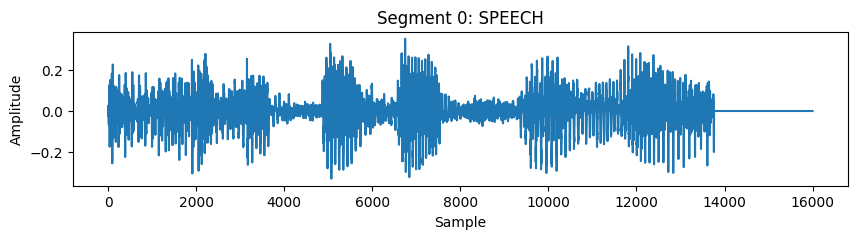

Using cached file: cache\B1MAUxpKaV8.mkv
Segment 1: Shape=torch.Size([1, 16000]), Label=NO_SPEECH


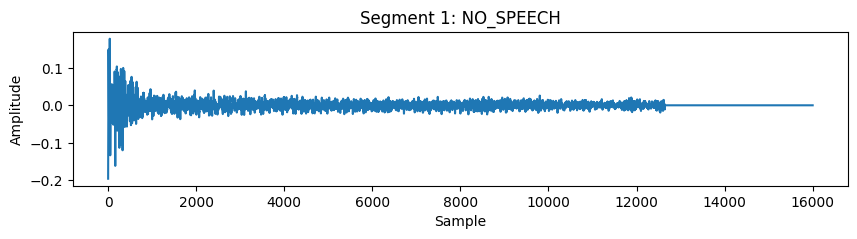

Using cached file: cache\B1MAUxpKaV8.mkv
Segment 2: Shape=torch.Size([1, 16000]), Label=SPEECH


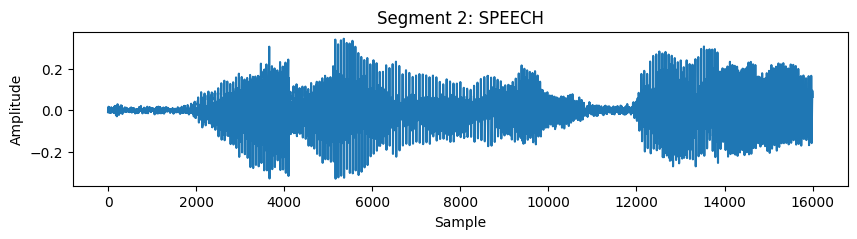

Using cached file: cache\B1MAUxpKaV8.mkv
Segment 3: Shape=torch.Size([1, 16000]), Label=NO_SPEECH


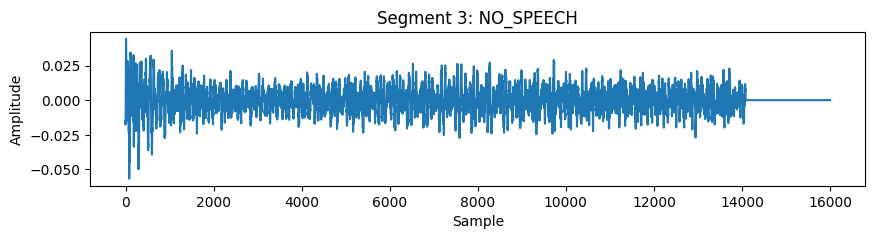

Using cached file: cache\B1MAUxpKaV8.mkv
Segment 4: Shape=torch.Size([1, 16000]), Label=SPEECH


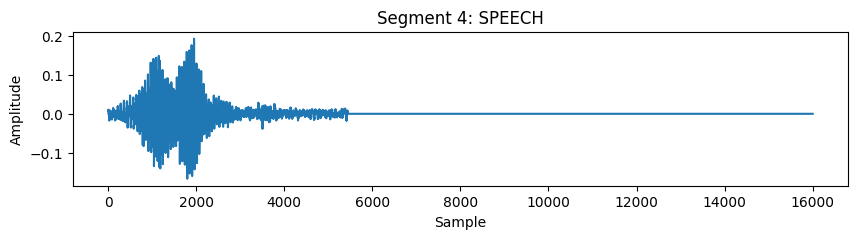

In [5]:
# Add this cell to test with a single video
import os
import torch
import pandas as pd
import torchaudio
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Select a single video file to test
test_video_id = "B1MAUxpKaV8"  # This is the first video ID in your labels
test_video_file = None

# Find the full file name for this video ID
with open("dataset/ava_speech_file_names_v1.txt", "r") as f:
    file_names = [line.strip() for line in f.readlines()]
    for name in file_names:
        if name.startswith(test_video_id):
            test_video_file = name
            break

if test_video_file:
    print(f"Testing with video: {test_video_file}")
    
    # Get labels for this video only
    all_labels = pd.read_csv(
        "dataset/ava_speech_labels_v1.csv", 
        header=None,
        names=["file_id", "start_time", "end_time", "label"]
    )
    
    # Filter labels for just this video
    video_labels = all_labels[all_labels["file_id"] == test_video_id]
    print(f"Found {len(video_labels)} label segments for this video")
    
    # Display first few labels
    print("\nFirst 5 label segments:")
    print(video_labels.head())
    
    # Create a mini dataset with just this video
    class SingleVideoDataset(torch.utils.data.Dataset):
        def __init__(self, video_file, labels_df, cache_dir="./cache", sample_rate=16000, segment_length=1.0):
            self.video_file = video_file
            self.labels_df = labels_df
            self.cache_dir = Path(cache_dir)
            self.cache_dir.mkdir(exist_ok=True, parents=True)
            self.sample_rate = sample_rate
            self.segment_length = segment_length
            
            # Map labels
            self.label_map = {
                "NO_SPEECH": 0,
                "CLEAN_SPEECH": 1,
                "SPEECH_WITH_MUSIC": 1,
                "SPEECH_WITH_NOISE": 1
            }
            
            # Create segments
            self.segments = self._prepare_segments()
            
        def _prepare_segments(self):
            segments = []
            for _, row in self.labels_df.iterrows():
                start_time = float(row["start_time"])
                end_time = float(row["end_time"])
                
                # Map label
                original_label = row["label"]
                if original_label not in self.label_map:
                    continue
                binary_label = self.label_map[original_label]
                
                # Break into smaller segments if needed
                duration = end_time - start_time
                if duration > self.segment_length:
                    # Create multiple segments
                    num_segments = int(duration / self.segment_length)
                    for i in range(num_segments):
                        seg_start = start_time + i * self.segment_length
                        seg_end = min(seg_start + self.segment_length, end_time)
                        segments.append({
                            "start_time": seg_start,
                            "end_time": seg_end,
                            "label": binary_label
                        })
                else:
                    segments.append({
                        "start_time": start_time,
                        "end_time": end_time,
                        "label": binary_label
                    })
            
            return segments
        
        def _download_file(self):
            """Download the video file if not in cache."""
            cache_path = self.cache_dir / self.video_file
            
            if not cache_path.exists():
                url = f"https://s3.amazonaws.com/ava-dataset/trainval/{self.video_file}"
                print(f"Downloading {self.video_file}...")
                
                try:
                    response = requests.get(url, stream=True)
                    response.raise_for_status()
                    
                    with open(cache_path, "wb") as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)
                    print("Download complete!")
                except Exception as e:
                    print(f"Error downloading {self.video_file}: {e}")
                    return None
            else:
                print(f"Using cached file: {cache_path}")
                    
            return str(cache_path)
        
        def extract_audio(self, video_path, start_time, end_time):
            """Extract audio from video file using ffmpeg."""
            try:
                import subprocess
                import tempfile
                import soundfile as sf
                
                # Create a temporary file for the audio segment
                temp_file = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
                temp_file.close()
                
                # Use ffmpeg to extract audio segment with specific format settings
                cmd = [
                    "ffmpeg", "-y",
                    "-i", video_path,
                    "-ss", str(start_time),
                    "-to", str(end_time),
                    "-ac", "1",  # Convert to mono
                    "-ar", str(self.sample_rate),  # Set sample rate
                    "-acodec", "pcm_s16le",  # Use PCM 16-bit format
                    "-vn",  # No video
                    temp_file.name
                ]
                
                # Run FFmpeg
                result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                
                if result.returncode != 0:
                    print(f"FFmpeg error: {result.stderr.decode('utf-8')}")
                    return None
                
                try:
                    # Try loading with soundfile
                    data, sr = sf.read(temp_file.name)
                    waveform = torch.tensor(data).unsqueeze(0)
                except Exception:
                    try:
                        # Fallback to torchaudio
                        waveform, sr = torchaudio.load(temp_file.name)
                    except Exception as e:
                        print(f"Error loading audio: {e}")
                        return None
                
                # Delete the temporary file
                os.unlink(temp_file.name)
                
                # Ensure we have the right sample rate
                if sr != self.sample_rate:
                    resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
                    waveform = resampler(waveform)
                
                # Ensure we have the right length (pad or trim)
                expected_length = int(self.segment_length * self.sample_rate)
                current_length = waveform.size(1)
                
                if current_length < expected_length:
                    # Pad with zeros
                    padding = torch.zeros(1, expected_length - current_length)
                    waveform = torch.cat([waveform, padding], dim=1)
                elif current_length > expected_length:
                    # Trim
                    waveform = waveform[:, :expected_length]
                    
                return waveform
                
            except Exception as e:
                print(f"Error extracting audio: {e}")
                return None
        
        def __len__(self):
            return len(self.segments)
        
        def __getitem__(self, idx):
            segment = self.segments[idx]
            start_time = segment["start_time"]
            end_time = segment["end_time"]
            label = segment["label"]
            
            # Download the file once (if not already cached)
            video_path = self._download_file()
            if video_path is None:
                return torch.zeros(1, int(self.sample_rate * self.segment_length)), 0
            
            # Extract the audio segment
            waveform = self.extract_audio(video_path, start_time, end_time)
            if waveform is None:
                return torch.zeros(1, int(self.sample_rate * self.segment_length)), 0
                
            return waveform, label
    
    # Create the single video dataset
    single_dataset = SingleVideoDataset(
        test_video_file, 
        video_labels,
        sample_rate=16000,
        segment_length=1.0
    )
    
    print(f"\nCreated dataset with {len(single_dataset)} segments")
    
    # Get first 5 audio segments
    print("\nLoading first few segments...")
    for i in range(min(5, len(single_dataset))):
        waveform, label = single_dataset[i]
        print(f"Segment {i}: Shape={waveform.shape}, Label={'SPEECH' if label == 1 else 'NO_SPEECH'}")
        
        # Plot the waveform
        plt.figure(figsize=(10, 2))
        plt.plot(waveform[0].numpy())
        plt.title(f"Segment {i}: {'SPEECH' if label == 1 else 'NO_SPEECH'}")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.show()
else:
    print(f"Video ID {test_video_id} not found in file names list.")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio
import numpy as np
from torch.utils.data import DataLoader, random_split
from ava_speech_dataset import AVASpeechDataset

In [ ]:
# Set paths
labels_file = "dataset/ava_speech_labels_v1.csv"
file_names_file = "dataset/ava_speech_file_names_v1.txt"
cache_dir = "./cache"  # Where to store downloaded files

# Set audio parameters
sample_rate = 16000  # Common for speech
segment_length = 1.0  # 1-second segments

In [ ]:
# Create dataset with basic transformation
transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

dataset = AVASpeechDataset(
    labels_file=labels_file,
    file_names_file=file_names_file,
    cache_dir=cache_dir,
    transform=transform,
    sample_rate=sample_rate,
    segment_length=segment_length
)

In [ ]:
# Split dataset into train/validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# Check class distribution
def check_class_distribution(dataset):
    speech_count = 0
    no_speech_count = 0
    
    for _, label in dataset:
        if label == 1:  # SPEECH
            speech_count += 1
        else:  # NO_SPEECH
            no_speech_count += 1
    
    total = speech_count + no_speech_count
    
    print(f"Total samples: {total}")
    print(f"SPEECH samples: {speech_count} ({speech_count/total*100:.2f}%)")
    print(f"NO_SPEECH samples: {no_speech_count} ({no_speech_count/total*100:.2f}%)")

# This might take a while as it needs to load all samples
# To speed up, you could sample a subset
sample_size = min(1000, len(dataset))
indices = torch.randperm(len(dataset))[:sample_size]
sample_dataset = torch.utils.data.Subset(dataset, indices)

print("Class distribution in sample:")
check_class_distribution(sample_dataset)

In [ ]:
# Visualize a few examples
def plot_examples(dataset, num_examples=3):
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, 3*num_examples))
    
    for i in range(num_examples):
        # Get a random sample
        idx = np.random.randint(0, len(dataset))
        mel_spec, label = dataset[idx]
        
        # Convert to dB scale for better visualization
        mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        
        # Plot
        axes[i].imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
        axes[i].set_title(f"Label: {'SPEECH' if label == 1 else 'NO_SPEECH'}")
        axes[i].set_ylabel('Mel Frequency')
        
    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()

# Plot examples
plot_examples(dataset)

## Simple VAD Model

In [ ]:
# Define a simple CNN model for VAD
class SimpleVAD(nn.Module):
    def __init__(self):
        super(SimpleVAD, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # The size here depends on your mel spectrogram dimensions
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze(1)

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        accuracy = 100 * correct / total
        
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'Accuracy: {accuracy:.2f}%')
    
    return train_losses, val_losses

In [ ]:
# Initialize and train model
model = SimpleVAD()
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=5)

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'vad_model.pth')